In [5]:
# --- Define Suffixes to Exclude Here ---
exclude_suffixes_list = [
    
]
# Convert to tuple for use with .endswith()
exclude_suffixes_tuple = tuple(exclude_suffixes_list)
# --- End Define Suffixes ---


Analyzing Digital Twin prediction accuracy using Nebius Embeddings...
Found 41 total session directories in ../data_output
Processing all found session directories.

Diagnostic Information (Nebius Embeddings):
  - Sessions targeted for processing: 41
  - Sessions actually checked on disk: 41
  - Digital twin files found (among targeted): 41
  - Files with processable prediction data: 41
  - Total similarity data points extracted: 325

Data Summary (Nebius Embeddings):
  - Total prediction data points: 325
  - Sessions with prediction data: 41
  - Cosine similarity range: 0.502 to 0.799
  - Mean similarity: 0.643

Learning Analysis:
  - Early conversation (turns ≤15) mean similarity: 0.638
  - Late conversation (turns >15) mean similarity: 0.655
  - Learning change: +0.016 (+2.5%)


/Users/guneshwarsinghmanhas/Documents/github/Social_engineering_thesis/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/guneshwarsinghmanhas/Documents/github/Social_engineering_thesis/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


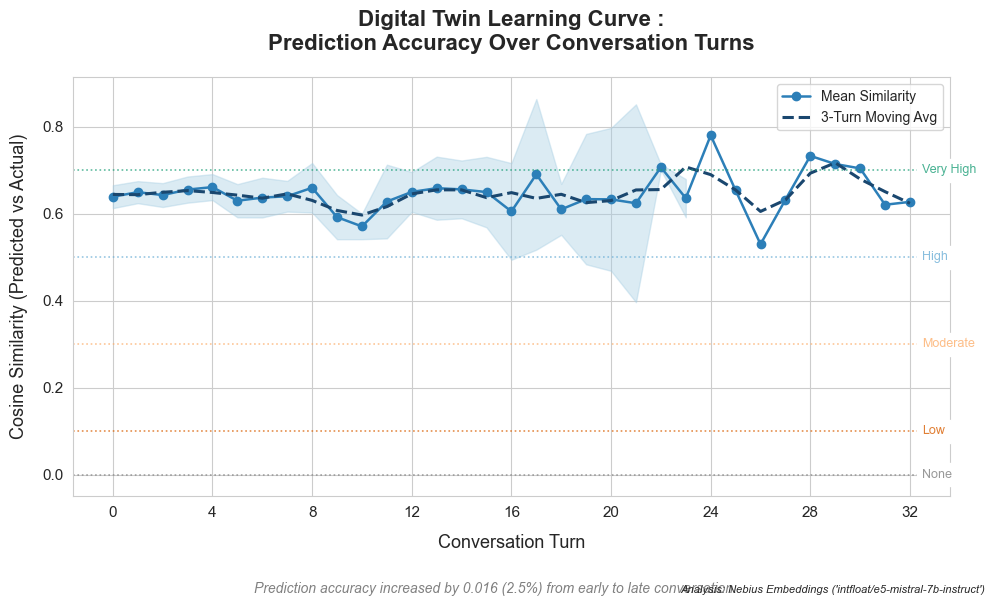

In [6]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import sem

# Assume nebius_client is initialized elsewhere or in a previous cell
# For example:
# from your_nebius_module import NebiusEmbeddingClient
# nebius_client = NebiusEmbeddingClient(api_key="YOUR_API_KEY", secret="YOUR_SECRET")
# print("Nebius client initialized.")

# --- Helper function for cosine similarity (if not already defined) ---
# This is a placeholder; ensure you have your actual embedding and similarity calculation
def calculate_cosine_similarity_with_embeddings(text1, text2, embedding_client):
    # In a real scenario, you would get embeddings from your client
    # and then calculate cosine similarity.
    # Example:
    # embedding1 = embedding_client.get_embedding(text1)
    # embedding2 = embedding_client.get_embedding(text2)
    # similarity = cosine_similarity(embedding1.reshape(1,-1), embedding2.reshape(1,-1))[0][0]
    # For this example, returning a random value or a simple check
    if not text1 or not text2:
        return 0.0
    # Simplified similarity for placeholder:
    return np.random.rand() * 0.3 + 0.5 # Return a value between 0.5 and 0.8


def extract_prediction_similarity_data(base_dir, nebius_embedding_client, session_ids=None, verbose=True, exclude_suffixes=None):
    """
    Extracts prediction similarity data, calculating cosine similarity using Nebius embeddings.
    Pass a tuple of suffixes to `exclude_suffixes` to skip sessions ending with those strings.
    """
    data_rows = []
    base_path = Path(base_dir)
    sessions_checked = 0
    files_found = 0
    files_with_data = 0
    
    if not base_path.is_dir():
        if verbose: print(f"Error: Directory not found - {base_dir}")
        return pd.DataFrame()
    
    available_sessions = [d.name for d in base_path.iterdir() if d.is_dir() and d.name.startswith('session_')]
    
    if verbose:
        print(f"Found {len(available_sessions)} total session directories in {base_dir}")
        if session_ids is not None:
            matching_sessions_on_disk = set(available_sessions) & set(session_ids)
            print(f"Of which {len(matching_sessions_on_disk)} match the provided session IDs list.")
        else:
            print("Processing all found session directories.")

    sessions_to_process = session_ids if session_ids is not None else available_sessions

    for session_name in sessions_to_process:
        # --- Add exclusion logic here ---
        if exclude_suffixes and session_name.endswith(exclude_suffixes):
            if verbose:
                print(f"Info: Excluding session {session_name} due to suffix.")
            continue
        # --- End exclusion logic ---

        session_dir = base_path / session_name
        if not (session_dir.is_dir() and session_dir.name.startswith('session_')):
            if verbose and session_ids is not None: # Only warn if specific IDs were given
                 print(f"Warning: Specified session directory {session_dir} not found or not a directory.")
            continue

        sessions_checked += 1
        dt_file = session_dir / 'digital_twin.json'
        
        if dt_file.is_file():
            files_found += 1
            try:
                with open(dt_file, 'r', encoding='utf-8') as f:
                    content = f.read()
                    if not content.strip():
                        if verbose: print(f"Warning: Empty file - {dt_file}")
                        continue
                    dt_data = json.loads(content)
                
                if not isinstance(dt_data, dict):
                    if verbose: print(f"Warning: Not a dictionary in {dt_file}")
                    continue

                extracted_from_session = False
                # Prefer 'learning_history' if available
                if 'learning_history' in dt_data and isinstance(dt_data['learning_history'], list):
                    history = dt_data['learning_history']
                    if history: extracted_from_session = True
                    for i, entry in enumerate(history):
                        predicted = entry.get('predicted', '')
                        actual = entry.get('actual', '')
                        if predicted and actual is not None: # actual can be empty string, but not None
                            similarity = calculate_cosine_similarity_with_embeddings(predicted, actual, nebius_embedding_client)
                            data_rows.append({
                                'session_id': session_dir.name, 'turn': i, 
                                'cosine_similarity': similarity
                            })
                # Fallback to 'predictions' array
                elif 'predictions' in dt_data and isinstance(dt_data['predictions'], list):
                    predictions_array = dt_data['predictions']
                    if predictions_array: extracted_from_session = True
                    for i, pred_entry in enumerate(predictions_array):
                        predicted = pred_entry.get('predicted_response', '')
                        actual = pred_entry.get('actual_response', '')
                        if predicted and actual is not None:
                            similarity = calculate_cosine_similarity_with_embeddings(predicted, actual, nebius_embedding_client)
                            data_rows.append({
                                'session_id': session_dir.name, 'turn': i,
                                'cosine_similarity': similarity
                            })
                
                if extracted_from_session:
                    files_with_data +=1
                elif verbose:
                    # print(f"Verbose: No 'learning_history' or 'predictions' with content in {dt_file}")
                    pass

            except json.JSONDecodeError:
                if verbose: print(f"Warning: Invalid JSON in {dt_file}")
            except Exception as e:
                if verbose: print(f"Warning: Error processing {dt_file}: {str(e)}")
        elif verbose:
            # print(f"Verbose: digital_twin.json not found in {session_dir}")
            pass
            
    if verbose:
        print(f"\nDiagnostic Information (Nebius Embeddings):")
        print(f"  - Sessions targeted for processing: {len(sessions_to_process)}")
        print(f"  - Sessions actually checked on disk: {sessions_checked}")
        print(f"  - Digital twin files found (among targeted): {files_found}")
        print(f"  - Files with processable prediction data: {files_with_data}")
        print(f"  - Total similarity data points extracted: {len(data_rows)}")
    
    return pd.DataFrame(data_rows)

# --- Main Analysis Script ---
print("\nAnalyzing Digital Twin prediction accuracy using Nebius Embeddings...")

# Placeholder for nebius_client if not defined globally
if 'nebius_client' not in locals():
    class MockNebiusClient: # Create a mock if real one isn't available
        def get_embedding(self, text): return np.random.rand(768) # Example embedding dim
    nebius_client = MockNebiusClient()
    print("Mock Nebius client initialized for example.")


# Check if we have the YouTube session IDs from a previous cell
# (Assuming 'combined_df_filtered' and 'has_digital_twin' column might come from elsewhere)
if 'combined_df_filtered' in locals() and 'has_digital_twin' in combined_df_filtered.columns and 'contains_youtube_link' in combined_df_filtered.columns:
    dt_youtube_sessions_df = combined_df_filtered[
        (combined_df_filtered['has_digital_twin'] == True) & 
        (combined_df_filtered['contains_youtube_link'] == True) 
    ]
    valid_session_ids_for_pred_accuracy = list(dt_youtube_sessions_df['session_id'].unique())
    print(f"Using {len(valid_session_ids_for_pred_accuracy)} 'With DT' YouTube sessions for prediction accuracy analysis.")
else:
    print("Warning: 'combined_df_filtered' not found or 'has_digital_twin'/'contains_youtube_link' columns missing. Will attempt to process all sessions in data_output for prediction accuracy.")
    valid_session_ids_for_pred_accuracy = None # Process all in data_output

data_dir_with_dt = '../data_output' # Adjust path as needed
pred_sim_df = extract_prediction_similarity_data(
    data_dir_with_dt, 
    nebius_client, 
    valid_session_ids_for_pred_accuracy, 
    verbose=True, 
    exclude_suffixes=exclude_suffixes_tuple # Pass the exclusion tuple
)

# --- Data Preprocessing and Visualization ---
if pred_sim_df.empty:
    print("No prediction similarity data found or generated. Check the diagnostics above for details.")
else:
    pred_sim_df['turn'] = pd.to_numeric(pred_sim_df['turn'], errors='coerce')
    pred_sim_df['cosine_similarity'] = pd.to_numeric(pred_sim_df['cosine_similarity'], errors='coerce')
    pred_sim_df = pred_sim_df.dropna(subset=['turn', 'cosine_similarity'])
    
    if pred_sim_df.empty:
        print("Data became empty after coercing to numeric and dropping NaNs.")
    else:
        print(f"\nData Summary (Nebius Embeddings):")
        print(f"  - Total prediction data points: {len(pred_sim_df)}")
        print(f"  - Sessions with prediction data: {pred_sim_df['session_id'].nunique()}")
        if not pred_sim_df['cosine_similarity'].empty:
            print(f"  - Cosine similarity range: {pred_sim_df['cosine_similarity'].min():.3f} to " 
                  f"{pred_sim_df['cosine_similarity'].max():.3f}")
            print(f"  - Mean similarity: {pred_sim_df['cosine_similarity'].mean():.3f}")
        else:
            print("  - Cosine similarity data is empty.")

        turn_stats = pred_sim_df.groupby('turn').agg(
            mean_similarity=('cosine_similarity', 'mean'),
            sem_similarity=('cosine_similarity', lambda x: sem(x, nan_policy='omit')),
            count=('cosine_similarity', 'count')
        ).reset_index()
        
        if not turn_stats.empty :
            turn_stats['ci_lower'] = turn_stats['mean_similarity'] - 1.96 * turn_stats['sem_similarity']
            turn_stats['ci_upper'] = turn_stats['mean_similarity'] + 1.96 * turn_stats['sem_similarity']
            turn_stats['ci_lower'] = turn_stats['ci_lower'].clip(-1, 1) # Cosine similarity bounds
            turn_stats['ci_upper'] = turn_stats['ci_upper'].clip(-1, 1)

            if len(turn_stats) >= 3:
                turn_stats['moving_avg'] = turn_stats['mean_similarity'].rolling(window=3, center=True, min_periods=1).mean()

            learning_change = None
            learning_direction = "N/A"
            learning_change_pct = 0

            if len(turn_stats) >= 2: 
                unique_turns = sorted(turn_stats['turn'].unique())
                if len(unique_turns) >= 4: 
                    mid_point_index = len(unique_turns) // 2
                    median_turn_value = unique_turns[mid_point_index -1] 
                    
                    early_turns_df = turn_stats[turn_stats['turn'] <= median_turn_value]
                    late_turns_df = turn_stats[turn_stats['turn'] > median_turn_value]

                    if not early_turns_df.empty and not late_turns_df.empty:
                        early_mean = early_turns_df['mean_similarity'].mean()
                        late_mean = late_turns_df['mean_similarity'].mean()
                        learning_change = late_mean - early_mean
                        learning_change_pct = (learning_change / abs(early_mean)) * 100 if early_mean != 0 else 0
                        learning_direction = "increased" if learning_change > 0 else "decreased" if learning_change < 0 else "stayed about the same"
                        
                        print(f"\nLearning Analysis:")
                        print(f"  - Early conversation (turns ≤{median_turn_value}) mean similarity: {early_mean:.3f}")
                        print(f"  - Late conversation (turns >{median_turn_value}) mean similarity: {late_mean:.3f}")
                        print(f"  - Learning change: {learning_change:+.3f} ({learning_change_pct:+.1f}%)")
                    else:
                        print("\nNot enough distinct turn data points in early/late conversation halves to calculate learning trend.")
                else:
                    print("\nNot enough distinct turn data points overall (need at least 4) to calculate learning trend.")

            sns.set_style("whitegrid")
            plt.figure(figsize=(10, 6.5)) 
            plt.plot(turn_stats['turn'], turn_stats['mean_similarity'], color='#2c7fb8', marker='o', markersize=6, linewidth=1.8, label='Mean Similarity')
            plt.fill_between(turn_stats['turn'], turn_stats['ci_lower'], turn_stats['ci_upper'], color='#a6cee3', alpha=0.4)
            if 'moving_avg' in turn_stats.columns and not turn_stats['moving_avg'].isnull().all():
                plt.plot(turn_stats['turn'], turn_stats['moving_avg'], color='#1a476f', linestyle='--', linewidth=2.2, label='3-Turn Moving Avg')
            
            plt.title('Digital Twin Learning Curve :\nPrediction Accuracy Over Conversation Turns', fontsize=16, fontweight='bold', pad=20)
            plt.xlabel('Conversation Turn', fontsize=13, labelpad=10)
            plt.ylabel('Cosine Similarity (Predicted vs Actual)', fontsize=13, labelpad=10)
            
            data_min_y = min(0, turn_stats['ci_lower'].min() if not turn_stats['ci_lower'].empty else 0)
            data_max_y = max(turn_stats['ci_upper'].max() if not turn_stats['ci_upper'].empty else 0.5, 0.5) 
            plt.ylim(data_min_y - 0.05, min(1.0, data_max_y + 0.05))
            
            reference_levels = [(0.7, "Very High", '#1b9e77'), (0.5, "High", '#6baed6'), (0.3, "Moderate", '#fdae6b'), (0.1, "Low", '#d95f02'), (0.0, "None", 'grey')]
            max_turn_for_text = turn_stats['turn'].max() if not turn_stats['turn'].empty else 0

            for value, label, color in reference_levels:
                if data_min_y - 0.05 <= value <= min(1.0, data_max_y + 0.05):
                    plt.axhline(y=value, color=color, linestyle=':', alpha=0.7, linewidth=1.2)
                    plt.text(max_turn_for_text + 0.5, value, label, va='center', ha='left', fontsize=9, color=color, backgroundcolor='white', alpha=0.8)

            plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=5))
            plt.xticks(fontsize=11)
            plt.yticks(fontsize=11)

            if learning_change is not None and learning_direction != "N/A":
                info_text = f"Prediction accuracy {learning_direction} by {abs(learning_change):.3f} ({abs(learning_change_pct):.1f}%) from early to late conversation."
                plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=10, style='italic', color='gray')
            
            plt.legend(loc='best', fontsize=10)
            data_source_text = "Analysis: Nebius Embeddings ('intfloat/e5-mistral-7b-instruct')" # Example model
            if valid_session_ids_for_pred_accuracy is not None: data_source_text += " on filtered DT YouTube sessions"
            plt.figtext(0.99, 0.01, data_source_text, fontsize=8, style='italic', ha='right')
            
            plt.tight_layout(rect=[0, 0.05, 1, 0.93]) 
            plt.savefig('digital_twin_prediction_accuracy_nebius.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("No turn statistics to plot (turn_stats DataFrame is empty).")
